In [26]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import random
import math
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, wait
executor = ThreadPoolExecutor(max_workers=5)

In [27]:
def normalEqn(X, y, _lambda, num_core):
    theta = np.array([x[0] for x in np.zeros((8, 1))])
    m = len(y) - 1
    J_min = np.zeros((int(m / num_core), 1))
    for t in range(1, int(m / num_core) + 1):
        theta = pd.DataFrame(np.linalg.inv(
            (
                    (X.iloc[0:num_core * t, :].transpose().dot(X.iloc[0:num_core * t, :]))
                    +
                    (_lambda * np.identity(8))
            )
        )).dot(X.iloc[0:num_core * t, :].transpose().dot(y[0:num_core * t]))
        J_min[t - 1] = ((sum(np.square((X.iloc[0:num_core * t, :].dot(theta)) - y[0:num_core * t]))) / 2) + (
                (_lambda / (2 * m)) * (sum(np.square(theta[0: len(theta) - 1]))))
    return (J_min, theta)

In [28]:
def computeCost(X, y, theta, theta_avg, i, _lambda, grad, num_core):
    m = len(y) - 1
    J = 0

    J = (np.square((X.iloc[i, :].dot(theta_avg)) - y[i]) / 2)
    + ((_lambda / 2 * m) * sum(np.square(theta[0: len(theta) - 1])))

    grad = ((X.iloc[i, :].dot(theta_avg)) - y[i]) * (X.iloc[i, :])

    grad[0: len(theta) - 1] = grad[0: len(theta) - 1] + ((_lambda / m) * theta_avg[0: len(theta) - 1])

    return (J, grad)

In [29]:
# Our proposed algorithm
def gradientDescent(X, y, theta, _lambda, num_core):
    m = len(y) - 1
    theta1 = theta
    theta2 = theta
    theta3 = theta
    theta_avg1 = theta
    theta_avg2 = theta
    theta_avg3 = theta
    theta_avg = theta
    J_history = np.zeros((int(m / num_core), 1))
    J_hist = np.zeros((num_core, 1))
    grad = np.array([x[0] for x in np.zeros((8, 1))])
    grad_par1 = grad
    grad_par2 = grad
    grad_par3 = grad
    grad_par4 = grad
    grad_rec1 = grad
    grad_rec2 = grad
    grad_rec3 = grad
    grad_rec4 = grad

    alpha = 1/m
    _eta = 2
    (J_hist[0], grad_par1) = computeCost(X, y, theta, theta_avg1, 0, _lambda, grad, num_core)
    theta1 = theta1 - ((alpha * _eta * grad_par1) / (
                _eta + num_core - 1))
    (J_hist[1], grad_par2) = computeCost(X, y, theta, theta_avg2, 1, _lambda, grad, num_core)
    theta2 = theta2 - ((alpha * _eta * grad_par2) / (
                _eta + num_core - 1))
    (J_hist[2], grad_par3) = computeCost(X, y, theta, theta_avg3, 2, _lambda, grad, num_core)
    theta3 = theta3 - ((alpha * _eta * grad_par3) / (
                _eta + num_core - 1))
    (J_hist[3], grad_par4) = computeCost(X, y, theta, theta_avg, 3, _lambda, grad, num_core)
    theta = theta - ((alpha * _eta * grad_par4) / (
                _eta + num_core - 1))

    J_history[0] = sum(J_hist)/num_core
    theta_avg1 = ((_eta * theta1) + sum(sum(theta, theta2), theta3)) / (_eta + num_core - 1)
    theta_avg2 = ((_eta * theta2) + sum(sum(theta1, theta), theta3)) / (_eta + num_core - 1)
    theta_avg3 = ((_eta * theta3) + sum(sum(theta1, theta2), theta)) / (_eta + num_core - 1)
    theta_avg = ((_eta * theta) + sum(sum(theta1, theta2), theta3)) / (_eta + num_core - 1)

    for x in range(num_core, m, num_core):
        #BELOW FOUR STEPS ARE PARALLEL
        data_1 = executor.submit(computeCost, X, y, theta1, theta_avg1, x, _lambda, grad, num_core)
        data_2 = executor.submit(computeCost, X, y, theta2, theta_avg2, x + 1, _lambda, grad, num_core)
        data_3 = executor.submit(computeCost, X, y, theta3, theta_avg3, x + 2, _lambda, grad, num_core)
        data_4 = executor.submit(computeCost, X, y, theta, theta_avg, x + 3, _lambda, grad, num_core)
        done, not_done = wait([data_1, data_2, data_3, data_4])
        done = list(done)
        (J_hist[0], grad_rec1) = done[0].result()
        (J_hist[1], grad_rec2) = done[1].result()
        (J_hist[2], grad_rec3) = done[2].result()
        (J_hist[3], grad_rec4) = done[3].result()
        theta1 = theta1 - ((alpha * _eta * grad_rec1) / (
                    _eta + num_core - 1))
        theta2 = theta2 - ((alpha * _eta * grad_rec2) / (
                    _eta + num_core - 1))
        theta3 = theta3 - ((alpha * _eta * grad_rec3) / (
                    _eta + num_core - 1))
        theta = theta - ((alpha * _eta * grad_rec4) / (
                    _eta + num_core - 1))

        if x % 3 == 0:
            theta_avg1 = ((_eta * theta1) + sum(sum(theta, theta2), theta3)) / (_eta + num_core - 1)
            theta_avg2 = ((_eta * theta2) + sum(sum(theta1, theta), theta3)) / (_eta + num_core - 1)
            theta_avg3 = ((_eta * theta3) + sum(sum(theta1, theta2), theta)) / (_eta + num_core - 1)
            theta_avg = ((_eta * theta) + sum(sum(theta1, theta2), theta3)) / (_eta + num_core - 1)
        J_history[int(x / 4)] = J_history[int(x / 4) - 1] + (sum(J_hist)/num_core)
    return (J_history, theta)

In [30]:
data_df = pd.read_csv('test_data.csv', header=None)
X = data_df.iloc[:, :7]
y = data_df.iloc[:, 7]
num_core = 4
m = len(y)
print("Normalizing Features ...\n")

temp_values = X.values  # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(temp_values)
X = pd.DataFrame(x_scaled)

# add a new columns of one
X[len(X.columns)] = 1

print(X.head())

theta = np.array([x[0] for x in np.zeros((8, 1))])

_lambda = 0.001

Normalizing Features ...

          0         1         2         3         4         5         6  7
0  0.513514  0.521008  0.084071  0.181335  0.150303  0.132324  0.147982  1
1  0.371622  0.352941  0.079646  0.079157  0.066241  0.063199  0.068261  1
2  0.614865  0.613445  0.119469  0.239065  0.171822  0.185648  0.207773  1
3  0.493243  0.521008  0.110619  0.182044  0.144250  0.149440  0.152965  1
4  0.344595  0.336134  0.070796  0.071897  0.059516  0.051350  0.053313  1


In [31]:
(J_history, OGD_theta) = gradientDescent(X, y, theta, _lambda, num_core)
print("Theta found by gradient descent", OGD_theta)

Theta found by gradient descent 0    0.240541
1    0.237174
2    0.050217
3    0.115903
4    0.089034
5    0.092365
6    0.100073
7    0.397602
dtype: float64


Theta found by normal equation 0    -1.161302
1     7.953341
2    13.358199
3    26.066015
4   -30.047384
5    -7.446509
6     8.622813
7     3.607345
dtype: float64


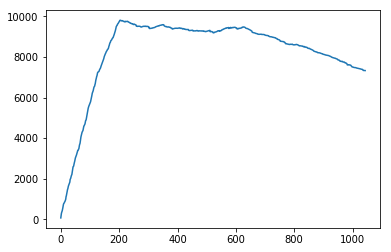

In [32]:
(J_min, normal_theta) = normalEqn(X, y, _lambda, num_core)
print("Theta found by normal equation", normal_theta);
regret = (J_history - J_min)*1.2
#print(regret)
plt.plot(regret)
plt.show()

In [33]:
import sys

orig_stdout = sys.stdout
f = open('outputDAOL_tau3.txt', 'w')
sys.stdout = f

for i in range(int(m/num_core)):
    print(regret[i])

sys.stdout = orig_stdout
f.close()